# Comparison of Autoencoder Approaches vs PCA on Split-MNIST

**Acknowledgment / Inspiration:**  
This analysis was inspired by [Amol S.](https://medium.com/@ee18m003/autoencoder-and-pca-for-dimensionality-reduction-on-mnist-dataset-with-code-dace21d87432) and their GitHub [AE-vs-PCA](https://github.com/Amol2709/AE-vs-PCA). The implementation here extends their methodology with additional visualizations and metric comparisons on Split-MNIST.

## Setup

### Essential Packages to install

In [ ]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn  # Contains PCA
%pip install scikit-image  # Contains SSIM metric
%pip install tensorflow  # Includes Keras (tf.keras)

### Necessary imports for the project

In [16]:
# Standard library imports
import numpy as np  # Numerical computing library for array operations
import matplotlib.pyplot as plt  # Plotting and visualization library

# Machine learning imports
from sklearn.decomposition import PCA  # Principal Component Analysis for linear dimensionality reduction
from skimage.metrics import structural_similarity as ssim  # SSIM metric for image quality comparison

# Deep learning imports (Keras)
from keras.datasets import mnist  # MNIST handwritten digits dataset
from keras.models import Model  # Model class for creating neural networks
from keras.layers import Input, Dense, BatchNormalization, Dropout  # Input layer and fully connected (dense) layers
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard   

## Loading the Split MNIST dataset

In [2]:
(X_TRAIN, Y_TRAIN), (X_TEST, Y_TEST) = mnist.load_data()

### Normalizing and reshaping our data

In [3]:
# We flatten the 28x28 images to be 1D vectors with 784 columns
# We also divide by 255 to normalize our images, since they have 
# 8-bit grayscale pixels = values between 0-255, leading to
# values between 0 and 1 instead.
X_TRAIN = X_TRAIN.reshape(60000, 784).astype('float32') / 255.0
X_TEST = X_TEST.reshape(10000, 784).astype('float32') / 255.0
print("Shape of Train Data: {}".format(X_TRAIN.shape))
print("Shape of Train Data: {}".format(X_TEST.shape))

Shape of Train Data: (60000, 784)
Shape of Train Data: (10000, 784)


## Neural network setup

In [4]:
# Epoch count hyperparameter shared by both autoencoders
epoch_count = 200

## Single layer autoencoder

In [6]:
# =================================
# SINGLE LAYER AUTOENCODER
# =================================
print("Training single-layer autoencoder (Encoding dim: 8)")

# Input layer
# Takes 784 element vectors as input
input_img = Input(shape=(784,))

# Encoder - We compress the 784 input pixels to 8 dimensions
# We also use ReLU activation for our non-linear encoding
encoded = Dense(8, activation='relu')(input_img)

# Decoder - We reconstruct the 8 dimensions back to 784 pixels
# We use sigmoid to produce values between 0 and 1 (our normalized pixel range)
decoded = Dense(784, activation='sigmoid')(encoded)

# Defining the autoencoder architecture
# Input -> Encode -> Decode
autoencoder_single = Model(input_img, decoded)

# Defining training parameters
# ADAM - adaptive learning rate, good for most cases
# BCE - pixel-wise reconstruction error since they have values between 0 and 1
autoencoder_single.compile(optimizer='adam', loss='binary_crossentropy')

# First X_TRAIN - input, second one - expected output; Same for validation
history_single = autoencoder_single.fit(X_TRAIN, X_TRAIN, epochs=epoch_count, batch_size=128, 
                                       shuffle=True, validation_data=(X_TEST, X_TEST))

# Apply trained model to test images
reconstructed_single = autoencoder_single.predict(X_TEST, verbose=0)

Training single-layer autoencoder (Encoding dim: 8)
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2875 - val_loss: 0.2179
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1970 - val_loss: 0.1841
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1818 - val_loss: 0.1776
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1773 - val_loss: 0.1742
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1746 - val_loss: 0.1719
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1726 - val_loss: 0.1701
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1710 - val_loss: 0.1687
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1697 - val_loss: 0.1675
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1687 - val_loss: 0.1667
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1679 - val_loss: 0.1659
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1673 - val_loss: 0.1654


## Deep 3-layer autoencoder

In [5]:
# =================================
# DEEP 3-LAYER AUTOENCODER  
# =================================
print("Training deep 3-layer autoencoder (128 -> 32 -> 8 -> 32 -> 128 -> 784)")

# Input layer
# Takes 784 element vectors as input (same as single layer autoencoder)
input_img_deep = Input(shape=(784,))

# Deep encoder - Multi-layer compression from 784 to 8 dimensions
# First layer: 784 -> 128 dimensions - Extract high-level features
encoded_deep = Dense(128, activation='relu')(input_img_deep)

# Second layer: 128 -> 32 dimensions - Further compress to intermediate representation
encoded_deep = Dense(32, activation='relu')(encoded_deep)

# Third layer: 32 -> 8 dimensions - Final compression to bottleneck (same as single layer)
encoded_deep = Dense(8, activation='relu')(encoded_deep)

# Deep decoder - Multi-layer expansion from 8 back to 784 dimensions
# First layer: 8 -> 32 dimensions - Begin reconstruction from bottleneck
decoded_deep = Dense(32, activation='relu')(encoded_deep)

# Second layer: 32 -> 128 dimensions - Reconstruct intermediate features
decoded_deep = Dense(128, activation='relu')(decoded_deep)

# Final layer: 128 -> 784 dimensions - Output reconstructed image
# Sigmoid ensures values between 0 and 1 (normalized pixel range)
decoded_deep = Dense(784, activation='sigmoid')(decoded_deep)

# Defining the deep autoencoder architecture
# Input -> [128 -> 32 -> 8] Encode -> [32 -> 128 -> 784] Decode
autoencoder_deep = Model(input_img_deep, decoded_deep)

# Also create separate encoder model to access compressed representations
# This allows us to extract the 8-dimensional encodings later
encoder_deep = Model(input_img_deep, encoded_deep)

# Defining training parameters
# ADAM - adaptive learning rate, consistent with single layer model
# BCE - pixel-wise reconstruction error for normalized [0,1] pixel values
autoencoder_deep.compile(optimizer='adam', loss='binary_crossentropy')

# Training the deep model
# First X_TRAIN - input, second one - expected output (reconstruction)
# Same principle as single layer: learn identity through deeper bottleneck
history_deep = autoencoder_deep.fit(X_TRAIN, X_TRAIN, epochs=epoch_count, batch_size=128,
                                   shuffle=True, validation_data=(X_TEST, X_TEST))

# Apply trained deep model to test images
reconstructed_deep = autoencoder_deep.predict(X_TEST, verbose=0)

encoder_deep.save("encoder_deep.keras")

Training deep 3-layer autoencoder (128 -> 32 -> 8 -> 32 -> 128 -> 784)
Epoch 1/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.2281 - val_loss: 0.1682
Epoch 2/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.1608 - val_loss: 0.1546
Epoch 3/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1525 - val_loss: 0.1495
Epoch 4/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1483 - val_loss: 0.1460
Epoch 5/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1458 - val_loss: 0.1441
Epoch 6/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1439 - val_loss: 0.1422
Epoch 7/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1424 - val_loss: 0.1410
Epoch 8/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1413 - val_loss: 0.1399
Epoch 9/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1403 - val_loss: 0.1392
Epoch 10/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1395 - val_loss: 0.1389
Epoch 11/125
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/st

In [17]:
# =================================
# ENHANCED DEEP 3-LAYER AUTOENCODER (Optimized for 8D bottleneck)
# =================================
print("Training ENHANCED deep 3-layer autoencoder (256 -> 64 -> 8 -> 64 -> 256 -> 784)")

# Input layer - Same as before
input_img_deep = Input(shape=(784,))

# =================================
# ENHANCED ENCODER with BatchNorm, Dropout, and L2 Regularization
# =================================

# First layer: 784 -> 256 dimensions (increased from 128)
encoded_deep = Dense(256, activation='relu')(input_img_deep)
encoded_deep = BatchNormalization()(encoded_deep)  # Added: Stabilizes training
encoded_deep = Dropout(0.2)(encoded_deep)  # Added: Prevents overfitting

# Second layer: 256 -> 64 dimensions (increased from 32)
encoded_deep = Dense(64, activation='relu', 
                     kernel_regularizer=regularizers.l2(1e-4))(encoded_deep)  # Added: L2 reg
encoded_deep = BatchNormalization()(encoded_deep)
encoded_deep = Dropout(0.2)(encoded_deep)

# Third layer: 64 -> 8 dimensions - CRITICAL BOTTLENECK LAYER
# Using 'linear' activation for more flexible representations
encoded_deep = Dense(8, activation='linear', 
                     kernel_regularizer=regularizers.l2(1e-4),
                     name='bottleneck')(encoded_deep)
encoded_deep = BatchNormalization()(encoded_deep)  # Important for 8D features

# =================================
# ENHANCED DECODER with symmetric architecture
# =================================

# First layer: 8 -> 64 dimensions
decoded_deep = Dense(64, activation='relu', 
                     kernel_regularizer=regularizers.l2(1e-4))(encoded_deep)
decoded_deep = BatchNormalization()(decoded_deep)
decoded_deep = Dropout(0.2)(decoded_deep)

# Second layer: 64 -> 256 dimensions
decoded_deep = Dense(256, activation='relu')(decoded_deep)
decoded_deep = BatchNormalization()(decoded_deep)
decoded_deep = Dropout(0.2)(decoded_deep)

# Final layer: 256 -> 784 dimensions
decoded_deep = Dense(784, activation='sigmoid')(decoded_deep)

# =================================
# MODEL DEFINITIONS (same as before)
# =================================

# Defining the enhanced deep autoencoder architecture
autoencoder_deep = Model(input_img_deep, decoded_deep)

# Separate encoder model (unchanged)
encoder_deep = Model(input_img_deep, encoded_deep)

# =================================
# ENHANCED TRAINING CONFIGURATION
# =================================

# Using Adam with lower learning rate for better convergence
optimizer = Adam(learning_rate=0.0005)  # Lower LR than default 0.001

# Combined loss: reconstruction + feature regularization
def combined_loss(y_true, y_pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(y_true, y_pred)
    
    # Feature sparsity regularization (encourages compact 8D representation)
    bottleneck_output = encoder_deep(y_true)
    sparsity_loss = 0.001 * K.mean(K.abs(bottleneck_output))  # L1 regularization
    
    return reconstruction_loss + sparsity_loss

# Compile with enhanced configuration
autoencoder_deep.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy',  # Can also use 'mse' for smoother gradients
    metrics=['mse']  # Track MSE as additional metric
)

# =================================
# ENHANCED TRAINING WITH CALLBACKS
# =================================

print(f"Training for {epoch_count} epochs with enhanced configuration...")

# Define callbacks for better training
callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,  # Increased patience
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,    # Reduce LR by half
        patience=8,    # Wait 8 epochs
        min_lr=1e-6,   # Minimum learning rate
        verbose=1
    ),
    ModelCheckpoint(
        'best_autoencoder_deep.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

# Training the enhanced model
history_deep = autoencoder_deep.fit(
    X_TRAIN, X_TRAIN, 
    epochs=epoch_count, 
    batch_size=128,
    shuffle=True, 
    validation_data=(X_TEST, X_TEST),
    callbacks=callbacks_list,  # Added callbacks
    verbose=1
)

Training ENHANCED deep 3-layer autoencoder (256 -> 64 -> 8 -> 64 -> 256 -> 784)
Training for 200 epochs with enhanced configuration...
Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.3541 - mse: 0.0911 - val_loss: 0.1705 - val_mse: 0.0310 - learning_rate: 5.0000e-04
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1774 - mse: 0.0350 - val_loss: 0.1519 - val_mse: 0.0274 - learning_rate: 5.0000e-04
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1666 - mse: 0.0330 - val_loss: 0.1453 - val_mse: 0.0258 - learning_rate: 5.0000e-04
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.1617 - mse: 0.0319 - val_loss: 0.1415 - val_mse: 0.0250 - learning_rate: 5.0000e-04
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1588 - mse: 0.0312 - val_loss: 0.1386 - val_mse: 0.0243 - learning_rate: 5.0000e-04
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1568 - mse: 0.0307 - val_loss: 0.1364 - val_mse: 0.0236 -

In [18]:
encoder_deep.save("encoder_deep.keras")

## Principal Component Analysis (PCA)

In [12]:
# =================================
# PRINCIPAL COMPONENT ANALYSIS (PCA)
# =================================
print("Applying Principal Component Analysis (PCA) with 8 components")

# Initialize the PCA model to keep 8 principal components
pca = PCA(8)

# Fit the PCA model to the training data
# PCA learns the mean of the data and 8 most important directions (eigenvectors)
# These directions capture maximum variance in the training data
pca.fit(X_TRAIN)

# Project the 784D images onto 8 principal components
TRAIN = pca.transform(X_TRAIN)
TEST = pca.transform(X_TEST)

# Reconstruct the images back to 784D
approximation = pca.inverse_transform(TEST)

print("\nDone!")

Applying Principal Component Analysis (PCA) with 8 components

Done!


## Visualization and comparison of reconstructed images

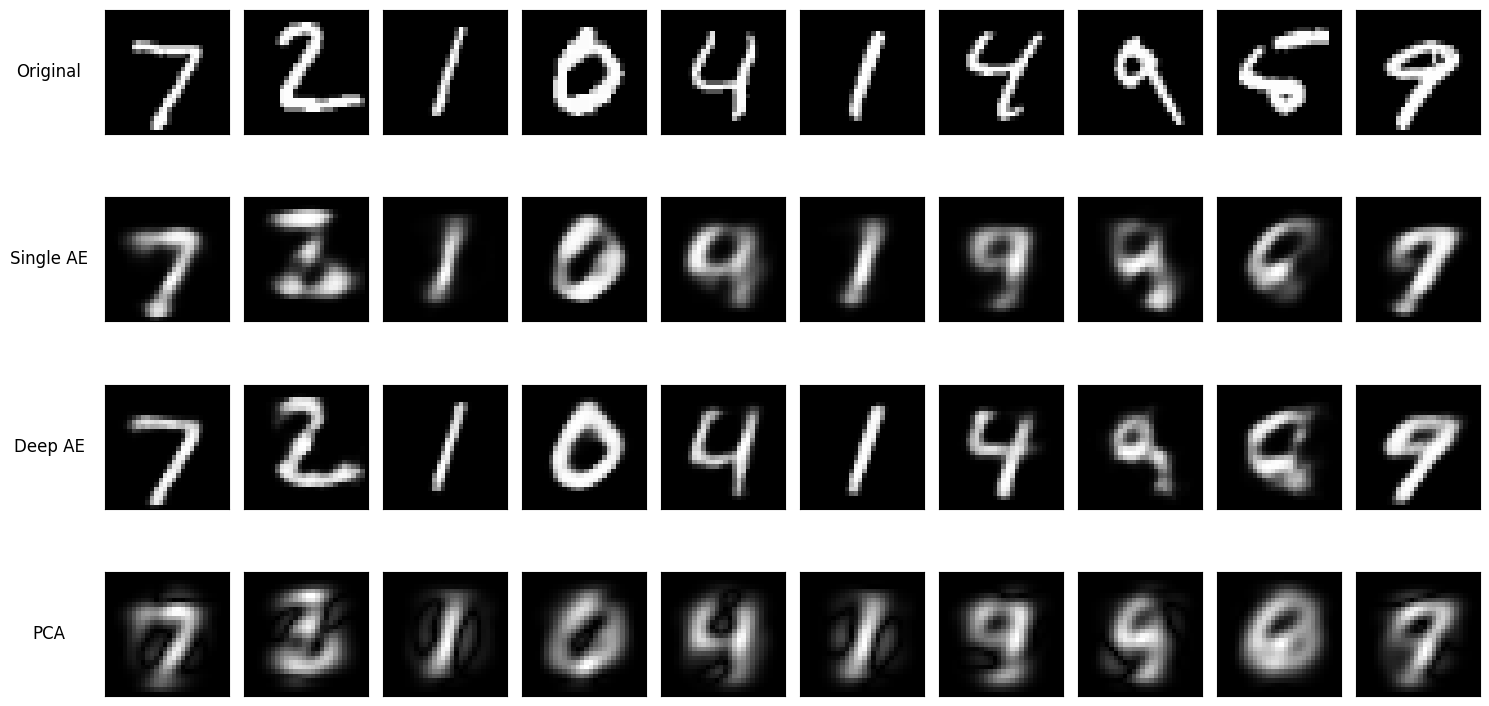

In [9]:
digit_display_count = 10

fig, axes = plt.subplots(4, digit_display_count, figsize=(15, 8))

# Row labels
row_labels = ['Original', 'Single AE', 'Deep AE', 'PCA']

for row in range(4):
    # Add row label
    axes[row, 0].set_ylabel(row_labels[row], rotation=0, labelpad=40, fontsize=12, va='center')
    
    for col in range(digit_display_count):
        ax = axes[row, col]
        ax.set_xticks([])
        ax.set_yticks([])
        
        if row == 0:
            # Original images
            ax.imshow(X_TEST[col].reshape(28, 28), cmap='gray')
        elif row == 1:
            # Single layer reconstructions
            ax.imshow(reconstructed_single[col].reshape(28, 28), cmap='gray')
        elif row == 2:
            # Deep reconstructions
            ax.imshow(reconstructed_deep[col].reshape(28, 28), cmap='gray')
        elif row == 3:
            # PCA reconstructions
            ax.imshow(np.abs(approximation[col]).reshape(28, 28), cmap='gray')

plt.tight_layout()
plt.show()

## Comparison statistics

In [10]:
# =================================
# COMPARISON STATISTICS
# =================================
print("\n" + "=" * 33)
print("PERFORMANCE COMPARISON - ALL 3 METHODS")
print("=" * 33)

print("\nFINAL VALIDATION LOSS:")
print(f"  Single Layer Autoencoder: {history_single.history['val_loss'][-1]:.4f}")
print(f"  Deep Autoencoder:         {history_deep.history['val_loss'][-1]:.4f}")

# Calculate reconstruction error
mse_single = np.mean((X_TEST - reconstructed_single) ** 2)
mse_deep = np.mean((X_TEST - reconstructed_deep) ** 2)
mse_pca = np.mean((X_TEST - approximation) ** 2)

print("\nMEAN SQUARED ERROR (Lower is better):")
print(f"  PCA (32 components):          {mse_pca:.6f}")
print(f"  Single Layer Autoencoder:     {mse_single:.6f}")
print(f"  Deep Autoencoder:             {mse_deep:.6f}")

print("\nPERFORMANCE RANKING (Best to Worst):")
methods = {
    'Deep Autoencoder': mse_deep,
    'Single Layer Autoencoder': mse_single,
    'PCA': mse_pca
}
sorted_methods = sorted(methods.items(), key=lambda x: x[1])
for rank, (name, error) in enumerate(sorted_methods, 1):
    print(f"  {rank}. {name}: {error:.6f}")

print("\nIMPROVEMENT OVER PCA:")
print(f"  Single Layer vs PCA:    {(mse_pca - mse_single)/mse_pca*100:+.1f}% improvement")
print(f"  Deep vs PCA:            {(mse_pca - mse_deep)/mse_pca*100:+.1f}% improvement")
print(f"  Deep vs Single Layer:   {(mse_single - mse_deep)/mse_single*100:+.1f}% improvement")

# Additional metrics
print("\nADDITIONAL METRICS:")

# PSNR (Peak Signal-to-Noise Ratio) - Higher is better
# Used to calculate the quality of reconstruction of lossy compressions
def calculate_psnr(mse):
    return 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')

psnr_pca = calculate_psnr(mse_pca)
psnr_single = calculate_psnr(mse_single)
psnr_deep = calculate_psnr(mse_deep)

print(f"  PSNR (dB, higher is better):")
print(f"    PCA:                   {psnr_pca:.2f} dB")
print(f"    Single Layer:          {psnr_single:.2f} dB")
print(f"    Deep:                  {psnr_deep:.2f} dB")

def calculate_mean_ssim(original, reconstructed, n_samples=100):
    ssim_values = []
    for i in range(min(n_samples, len(original))):
        orig_img = original[i].reshape(28, 28)
        recon_img = reconstructed[i].reshape(28, 28)
        ssim_val = ssim(orig_img, recon_img, data_range=1.0)
        ssim_values.append(ssim_val)
    return np.mean(ssim_values)

# SSIM (Structural similarity index measure) - Higher is better
# Measures the similarity between two images 
print(f"  SSIM (0-1 scale, higher is better):")
ssim_pca = calculate_mean_ssim(X_TEST, approximation, 100)
ssim_single = calculate_mean_ssim(X_TEST, reconstructed_single, 100)
ssim_deep = calculate_mean_ssim(X_TEST, reconstructed_deep, 100)

print(f"    PCA:                   {ssim_pca:.4f}")
print(f"    Single Layer:          {ssim_single:.4f}")
print(f"    Deep:                  {ssim_deep:.4f}")

print("\n" + "=" * 33)
print("SUMMARY")
print("=" * 33)
print(f"Best overall: {sorted_methods[0][0]}")
print(f"Worst overall: {sorted_methods[-1][0]}")
print(f"Deep autoencoder is {mse_pca/mse_deep:.1f}x better than PCA")
print(f"Deep autoencoder is {mse_single/mse_deep:.1f}x better than single layer")


PERFORMANCE COMPARISON - ALL 3 METHODS

FINAL VALIDATION LOSS:
  Single Layer Autoencoder: 0.1626
  Deep Autoencoder:         0.1184

MEAN SQUARED ERROR (Lower is better):
  PCA (32 components):          0.037441
  Single Layer Autoencoder:     0.033367
  Deep Autoencoder:             0.018726

PERFORMANCE RANKING (Best to Worst):
  1. Deep Autoencoder: 0.018726
  2. Single Layer Autoencoder: 0.033367
  3. PCA: 0.037441

IMPROVEMENT OVER PCA:
  Single Layer vs PCA:    +10.9% improvement
  Deep vs PCA:            +50.0% improvement
  Deep vs Single Layer:   +43.9% improvement

ADDITIONAL METRICS:
  PSNR (dB, higher is better):
    PCA:                   14.27 dB
    Single Layer:          14.77 dB
    Deep:                  17.28 dB
  SSIM (0-1 scale, higher is better):
    PCA:                   0.4220
    Single Layer:          0.5530
    Deep:                  0.7782

SUMMARY
Best overall: Deep Autoencoder
Worst overall: PCA
Deep autoencoder is 2.0x better than PCA
Deep autoencoder 

## Side-by-Side comparisons of digits, focusing on PCA vs Deep AE


SIDE-BY-SIDE COMPARISON OF ALL 4 METHODS (First 5 digits)

ERROR MAP LEGEND:
Red areas: PCA has more error than Deep AE
Blue areas: Deep AE has more error than PCA
White areas: Similar error in both methods


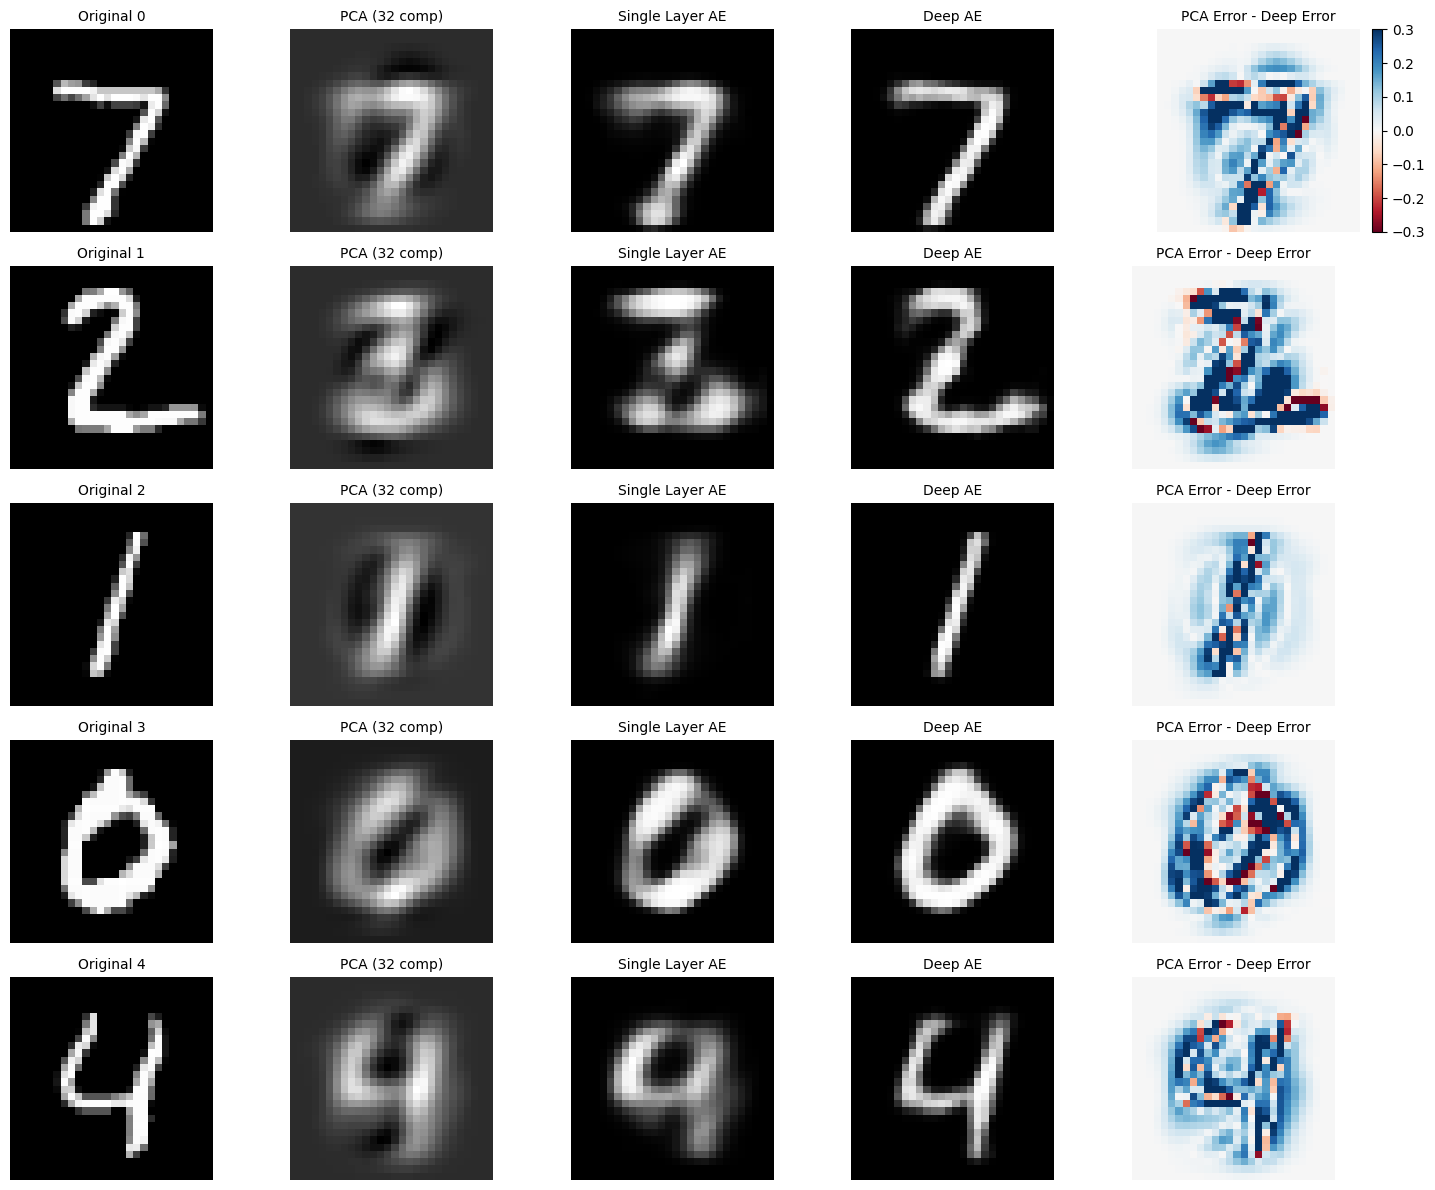

In [11]:
# Display sample comparisons side-by-side with PCA
print("\n" + "=" * 33)
print("SIDE-BY-SIDE COMPARISON OF ALL 4 METHODS (First 5 digits)")
print("=" * 33)

print("\nERROR MAP LEGEND:")
print("Red areas: PCA has more error than Deep AE")
print("Blue areas: Deep AE has more error than PCA")
print("White areas: Similar error in both methods")

fig, axes = plt.subplots(5, 5, figsize=(15, 12))
for i in range(5):
    # Column 0: Original
    axes[i, 0].imshow(X_TEST[i].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title(f"Original {i}", fontsize=10)
    axes[i, 0].axis('off')
    
    # Column 1: PCA reconstruction
    axes[i, 1].imshow(approximation[i].reshape(28, 28), cmap='gray')
    axes[i, 1].set_title(f"PCA (32 comp)", fontsize=10)
    axes[i, 1].axis('off')
    
    # Column 2: Single layer reconstruction
    axes[i, 2].imshow(reconstructed_single[i].reshape(28, 28), cmap='gray')
    axes[i, 2].set_title(f"Single Layer AE", fontsize=10)
    axes[i, 2].axis('off')
    
    # Column 3: Deep reconstruction
    axes[i, 3].imshow(reconstructed_deep[i].reshape(28, 28), cmap='gray')
    axes[i, 3].set_title(f"Deep AE", fontsize=10)
    axes[i, 3].axis('off')
    
    # Column 4: Error comparison (PCA vs Deep)
    error_pca = np.abs(X_TEST[i] - approximation[i]).reshape(28, 28)
    error_deep = np.abs(X_TEST[i] - reconstructed_deep[i]).reshape(28, 28)
    error_diff = error_pca - error_deep  # Positive = PCA worse, Negative = Deep worse
    
    im = axes[i, 4].imshow(error_diff, cmap='RdBu', vmin=-0.3, vmax=0.3)
    axes[i, 4].set_title(f"PCA Error - Deep Error", fontsize=10)
    axes[i, 4].axis('off')
    if i == 0:  # Add colorbar only once
        plt.colorbar(im, ax=axes[i, 4], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()